<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h1 style='color:GhostWhite;'>Should This Loan be Approved or Denied ?</h1>

An XGBoost data model to predict whether a loan can be approved or denied.<br>
    
Any comments are welcome.<br><br>
The Notebook is divided into 2 Parts:<br>
<ul>
<li><b>Part 1 :</b> Pipeline - this is the end result encapsulated into a pipeline</li><br>
<li><b>Part 2 :</b> Data Exploration (EDA) and Preparation, Modeling, Metrics - from start to end, with some notes to make sense of it</li>
</ul><br>
     "Our model results are way more dependent on how well feature engineering is performed than on the model itself. Machine Learning models are like very skilled linguists that can decipher any text in any language. However, it will not be helpful if they are handed a bunch of scribbles or blurred out text. EDA should not be skipped, as a thorough EDA and feature engineering process accounts for 90% of the results of a good model."
</div>

<div class="alert alert-block alert-success">  
    <b>Dataset Source</b>

https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied
<br><br>
    All information about the dataset can be found at the <b>above link</b>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Global variables</b></div>

In [297]:
'''
Change this kaggle_flag to :
   0 - if running outside Kaggle (e.g. Jupyter Notebook), change filepath & savepath to your own path
   1 - if running as a Kaggle notebook
'''
kaggle_flag = 0

if kaggle_flag == 1:
    filepath = "../input/should-this-loan-be-approved-or-denied/"  # Kaggle
    savepath = "./"   #Kaggle
else:
    filepath = "C:\\Python\\Python_Data_Science_Exercises\\datasets\\"
    savepath = "C:\\Python\\Python_Data_Science_Exercises\\datasets\\"

audio_path="https://www.soundjay.com/nature/sounds/lake-waves-01.mp3" # for alert

''' alert_flag - change to 0 for no sound alert, 1 for sound alert after long running cells '''
alert_flag = 1

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Tools</b></div>

In [298]:
piplist = !pip list

# for text-to-speech
if not piplist.grep('pyttsx3'):
    !pip3 install pyttsx3
    
# for oversampling
if not piplist.grep('imbalanced-learn'):
    !pip3 install imbalanced-learn

if not piplist.grep('pandas-profiling'):
    !pip3 install pandas-profiling

In [299]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pyttsx3
from IPython.display import Audio, display
#from IPython.display import FileLink
import hashlib
import copy      # for deepcopy()
import datetime as dt
%matplotlib inline  

In [300]:
''' 
Set up voice object.  Used in different areas of notebook to indicate completion of long processes.
'''
if kaggle_flag == 0:   # not Kaggle
    engine = pyttsx3.init()  # object creation

    """ RATE"""
    rate = engine.getProperty('rate')   # getting details of current speaking rate
    #print (rate)                        #printing current voice rate
    engine.setProperty('rate', 175)     # setting up new voice rate

    """VOLUME"""
    volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
    #print (volume)                         #printing current volume level
    engine.setProperty('volume',0.7)        # setting up volume level  between 0 and 1

    """VOICE"""
    voices = engine.getProperty('voices')       #getting details of current voice
    #engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
    engine.setProperty('voice', voices[1].id)   #changing index, changes voices. 1 for female

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Custom Functions and Classes</b></div>

In [301]:
class color:
   purple = '\033[95m'
   cyan = '\033[96m'
   darkcyan = '\033[36m'
   blue = '\033[94m'
   green = '\033[92m'
   yellow = '\033[93m'
   red = '\033[91m'
   bold = '\033[1m'
   underline = '\033[4m'
   end = '\033[0m'

In [302]:
def check_cols_with_nulls(df):
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
    if len(cols_with_missing) == 0:
        print("No Missing Values")
    else:
        print(cols_with_missing)
    
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [303]:
def check_infinity_nan(df,dfname):
    print("checking for infinity")
  
    #ds = sba.isin([np.inf, -np.inf])
    #print(ds)
  
    # printing the count of infinity values
    print()
    print("printing the count of infinity values")
  
    count = np.isinf(df).values.sum()
    print(f"{dfname} contains " + str(count) + " infinite values")
    print()
    
    has_nan = df.isnull().values.any()
    print(f"Does {dfname} have Nan or Null values ?  {has_nan}")

In [304]:
# used as a converter when loading csv
def fixvals(val):
    retval = val.replace('$','').replace(',','')
    return retval

In [305]:
def runtime(rt1,rt2):
    tdiff=rt2 - rt1
    # get seconds and convert to h:m:s
    print()
    print(f'Runtime : {str(dt.timedelta(seconds=tdiff.total_seconds()))}')

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Metrics Function</b></div>

In [423]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def model_eval(y_valid,predictions, cmDisplay='False'):
    print('MAE:', metrics.mean_absolute_error(y_valid, predictions))
    #print('MSE:', metrics.mean_squared_error(y_valid, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))
    print()
    
    ClassificationReport = classification_report(y_valid,predictions.round(),output_dict=True)

    print(color.bold + "Classification Report:" + color.end)
    print(classification_report(y_valid,predictions.round()))
    
    print()
    print(color.bold + "Confusion Matrix:" + color.end)

    if cmDisplay == True:
        cm = confusion_matrix(y_valid, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        fig, ax = plt.subplots(dpi=100,figsize=(5,5))
        disp.plot(ax=ax,colorbar=False,values_format='d')
    
    cmv = confusion_matrix(y_valid, predictions)
    
    TrueNeg = cmv[0][0]
    FalsePos = cmv[0][1]
    FalseNeg = cmv[1][0]
    TruePos = cmv[1][1]

    TotalNeg = TrueNeg + FalseNeg
    TotalPos = TruePos + FalsePos
    
    print()
    print(f'True Negative : CHGOFF (0) was predicted {TrueNeg} times correctly \
  ({round((TrueNeg/TotalNeg)*100,2)} %)')
    print(f'False Negative : CHGOFF (0) was predicted {FalseNeg} times incorrectly \
    ({round((FalseNeg/TotalNeg)*100,2)} %)')
    print(f'True Positive : P I F (1) was predicted {TruePos} times correctly \
    ({round((TruePos/TotalPos)*100,2)} %)')
    print(f'False Positive : P I F (1) was predicted {FalsePos} times incorrectly \
    ({round((FalsePos/TotalPos)*100,2)} %)')
    
    print()
    print(color.green + color.bold + "Accuracy for model: %.2f" % (accuracy_score(y_valid, \
                                                            predictions.round()) * 100) + color.end)
    print(color.blue + color.bold + 'f1-score:' + color.end)
    print(f"   CHGOFF (0) : {round(ClassificationReport['0']['f1-score']*100,2)}")
    print(f"   P I F (1)  : {round(ClassificationReport['1']['f1-score']*100,2)}")
    
    return {'cmv':cmv, 'ClassificationReport':ClassificationReport}

**Feature Importance**

In [307]:
from xgboost import plot_importance

# Plot feature importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize,dpi=600)
    return plot_importance(booster=booster, ax=ax)

**Mutual Information**

In [308]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    print()
    print("Please wait, Mutual Information gathering can take time ...")
    X = X.copy()
    #for colname in X.select_dtypes(["object", "category"]):
    #    X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    #mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = mutual_info_regression(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    print("Mutual Information gathering done ...")
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Machine Learning Class</b></div>

In [309]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
#from xgboost import XGBRegressor
from xgboost import XGBClassifier

class process_model():  
    def __init__(self, X, y):
        self.X = X
        self.y = y

        print('MIS_Status Count : ',Counter(y))
    
    # oversampling method
    def osample(self):
        # define oversampling strategy
        oversample = RandomOverSampler(sampling_strategy='minority') 
        print(len(self.X))
        print(len(self.y))
        # fit and apply the transform
        X_over, y_over = oversample.fit_resample(self.X, self.y)

        # summarize class distribution
        print('Before Oversampling : ',Counter(self.y))
        print('After Oversampling  : ',Counter(y_over))
        
        # update X and y with the oversampled results 
        self.X = X_over
        self.y = y_over
        
        # return the oversampled results in case they are needed in another module
        return {'X_over':X_over, 'y_over':y_over}
    
    # Method to run model 
    # X_size - size of X - e.g. 0.8
    # desc - description of metrics report
    def prep_run_model(self, X_size, desc='Metrics', cmDisplay=False, mn_estimators=1000, \
                       mlearning_rate=0.05,mmax_depth=6):
        self.X_size = X_size
        self.desc = desc
        self.mn_estimators = mn_estimators
        self.mlearning_rate = mlearning_rate
        self.mmax_depth = mmax_depth
        
        # Split Data into Train:Validate:Test
        
        # train_size=X_size

        # In the first step, we will split the data in training and remaining dataset
        X_train, X_rem, y_train, y_rem = train_test_split(self.X, self.y, train_size=self.X_size,\
                                                        random_state=101) 

        # Now since we want the valid and test size to be equal. 
        # we have to define valid_size=0.5 (that is 50% of remaining data)
        # test_size = 0.5

        X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem,test_size=0.5,\
                                                            random_state=101)
    
        print()
        print(color.bold + color.underline + "Shapes Before And After Splitting Dataset :" +\
              color.end)
        print('X',X.shape,end=''), print('   y', y.shape)
        print('X_train',X_train.shape,end=''), print('   y_train', y_train.shape)
        print('X_valid',X_valid.shape,end=''), print('   y_valid', y_valid.shape)
        print('X_test', X_test.shape, end=''), print('   y_test', y_test.shape)
    
        print()
        print(color.bold + "Please wait, Fitting model can take time ..." + color.end)
        
        '''
        XGBRegressor is for continuous target/outcome variables. These are often called 
        "regression problems."

        XGBClassifier is for categorical target/outcome variables. These are often called 
        "classification problems."
        
        xg_model = XGBRegressor(n_estimators = self.mn_estimators, \
                                learning_rate = self.mlearning_rate, \
                                max_depth = self.mmax_depth,\
                                n_jobs=4)
        '''
        xg_model = XGBClassifier(n_estimators = self.mn_estimators, \
                                learning_rate = self.mlearning_rate, \
                                max_depth = self.mmax_depth,\
                                use_label_encoder =False,\
                                n_jobs=4)
       
        xg_model.fit(X_train, y_train, 
                     early_stopping_rounds=5,
                     eval_metric=['logloss'],
                     eval_set=[(X_valid, y_valid)], 
                     verbose=False)
 
        print("Fitting model completed.")
    
        # Get predictions
        predictions = xg_model.predict(X_valid)
    
    
        print()
        print(color.underline + self.desc + color.end)

        model_eval(y_valid, predictions, cmDisplay)
            
        # Return these values as they will be needed for further testing or metrics
        # in dictionary form to remember easier 
        return {'xg_model':xg_model,'predictions':predictions, \
                    'X_train':X_train, 'y_train':y_train, \
                    'X_valid':X_valid, 'y_valid':y_valid, \
                    'X_test':X_test, 'y_test':y_test}

<div style="font-family: Trebuchet MS;background-color:DarkRed;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3 style='color:GhostWhite;'>Part 1. Pipeline</h3>
This pipeline handles both X and y
</div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>The PipeLine</b></div>

In [310]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
  
class PL_Object():
    def __init__(self,X,y):
        #store X and Y
        self.X=X
        self.y=y

class PreProcessor(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # check the parameters and return X and y inside the object
        X_data=X.X
        y_data=X.y
        
        print()
        print(color.bold + color.underline + f'PreProcessor initiated for {self.operation}.' +\
              color.end)
        
        #  do some work and assign it back to the X object which contains both X and y data
        if self.operation=='X':
            '''
            # NOTE: 'MIS_Status' is the target (y), but still in X, as we need to drop rows
                    with NaNs. We cannot do it separately, as there will be a mismatch in count 
                    of rows.  At the end of this procedure, we separate the new target data from X 
                    and update y.
            '''
            
            # 1. Drop Na from rows
            #---------------------
            print('1. Drop NaNs')
            X_data.dropna(subset=['DisbursementDate', 'NewExist', 'City', 'State',\
                        'State', 'Name', 'NAICS', 'CreateJob', 'RetainedJob', 'FranchiseCode',\
                        'UrbanRural', 'NoEmp', 'Term', 'MIS_Status'], how='all', inplace=True)
            
            # drop invalid classifications and Nans
            print('   Drop invalid classifications and NaNs')
            X_data = X_data[(X_data['LowDoc'] == 'Y') | (X_data['LowDoc'] == 'N')]
            
            X_data = X_data[(X_data['NewExist'] == 1) | (X_data['NewExist'] == 2)]   
            
            # Trim leading and trailing spaces
            #---------------------------------
            print('   Trim leading and trailing spaces, if any')
            X_data['City'] = X_data['City'].str.strip()
            
            # 2. Change dtype for columns needed for calculation or string extraction 
            #------------------------------------------------------------------------
            print('2. Change dtype for columns needed for calculation or string extraction')
            X_data = X_data.astype({'DisbursementGross':np.float64,'SBA_Appv':np.float64,\
                              'GrAppv':np.float64, 'ChgOffPrinGr':np.float64, 'NAICS':np.str_})
            
            # 3. Create New Features
            #-----------------------
            print('3. Create New Features')
            X_data['Industry'] = X_data['NAICS'].str[0:2]
            
            X_data['Recession'] = np.where((X_data['DisbursementDate'] >= '2007-09-01')\
                     & (X_data['DisbursementDate'] <= '2009-06-30'), 1, 0)
            
            X_data['RealEstate'] = np.where(X_data['Term'] >= 240, 1, 0)
            
            X_data['SBA_Portion']=(X_data['SBA_Appv']/X_data['GrAppv']) * 100
            
            X_data["CityState"] = X_data["City"] + "_" + X_data["State"]
                      
            # 4. convert small fields to dtype int32
            #---------------------------------------
            print('4. convert small fields to dtype int32')         
            X_data = X_data.astype({'Term':np.int32, 'NoEmp':np.int32, 'NewExist':np.int32, \
                                'CreateJob':np.int32, 'RetainedJob':np.int32,\
                                'FranchiseCode':np.int32, 'UrbanRural':np.int32,\
                                'Industry':np.int32}) 
            
            print()
            print(f"X length = {len(X_data)}")
            print(f"Y length = {len(X_data['MIS_Status'])}")
            
            # Update X object
            X.X = X_data                      # type DataFrame
            X.y = X_data.pop('MIS_Status')    # type series
            
        elif self.operation=='y':
            pass                      
        else:
            pass
        
        #return modified X object
        return X
    

class EncodeCategorical(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # encode categorical features and return X and y inside the object
        X_data=X.X
        y_data=X.y
        
        print()
        print(color.bold + color.underline + \
              f'Encode Categorical Features initiated for {self.operation}' + color.end)
        
        #  do some work and assign it back to the X object
        if self.operation=='X':         
            X_data['LowDoc'] = np.where((X_data['LowDoc'] == 'Y'), 1, 0)
            
            len_data=len(X_data)
            #cols_to_drop = []
            hash_constant = 900000   # fixed value so we can programmatically reproduce the hash
            #for col in X_data.columns:
            for col in X_data[['State','CityState']]:
                if X_data[col].dtype == 'object':
                    print(f'Column {col} has {X_data[col].nunique()} values among {len_data}')

                    if X_data[col].nunique() < 25:
                        print(f'One-hot encoding of {col}')
                        one_hot_cols = pd.get_dummies(X_data[col])
                        for ohc in one_hot_cols.columns:
                            X_data[col + '_' + ohc] = one_hot_cols[ohc]
                    else:
                      print(f'Hashing of {col}')
                      X_data[col + '_hash'] = X_data[col].apply(lambda row: int(hashlib.sha1((col +\
                                "_" + str(row)).encode('utf-8')).hexdigest(), 16) % hash_constant)

            X.X = X_data
            
        elif self.operation=='y':
            y_data = np.where(y_data == 'P I F', 1, 0)
            
            y_data = y_data.astype(np.int32)
            
            # convert back to series
            y_data = pd.Series(y_data)

            X.y = y_data                      
        else:
            pass
        #return modified X
        return X    

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_data=X.X
        
        print()
        print(color.bold + color.underline + \
              f'Drop Columns initiated for {self.operation}' + color.end)
        
        #  do some work and assign it back to the X object
 
        # Dropping 'City' as 'CityState_hash' is more ideal
        # Zip code has invalid values like 1, 2.  If we pad 0000 to 1, it's still not correct,
        # as state should be Alaska. Zip code 1 is different states in the dataset
        cols_to_drop = ['LoanNr_ChkDgt', 'Bank', 'BankState', 'ApprovalDate', \
                        'ApprovalFY', 'ChgOffDate', 'BalanceGross', 'NAICS', 'ChgOffPrinGr', \
                        'GrAppv','Zip']

        X_data.drop(columns=cols_to_drop, inplace=True)
            
        print()
        print('Unneeded Columns Dropped')
        print(X_data.info())

        X.X = X_data
            
        #return modified X
        return X    

class XGBoost(BaseEstimator, TransformerMixin):
    def __init__(self,operation= 'X'):
        self.operation=operation
    @staticmethod
    def enabled(**kwargs):
        return True

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_data=X.X
        y_data=X.y
        
        print()
        print(color.bold + color.underline + 'XGBoost initiated' + color.end)
        #print(len(X_data))
        #print(len(y_data))
        
        # Get predictions using training and validation data
        xg_model_run = process_model(X_data, y_data)
        xg_model_run.osample()
        xg_model_run_results = xg_model_run.prep_run_model(0.7, "Train/Valid Data Metrics",\
                                                          cmDisplay=True)   
        
        #Test with unseen data
        print()
        print(color.bold + color.underline + 'Test With Unseen Data X_test and y_test' + color.end)
        
        xg_model = xg_model_run_results['xg_model']
        x_test = xg_model_run_results['X_test']
        y_test = xg_model_run_results['y_test']
        
        # Get predictions
        predictions = xg_model.predict(x_test)
        cmv = model_eval(y_test, predictions)

        X.X = X_data
            
        '''
        A dictionary is returned, and its values can be used outside the pipeline if needed
        
        {'xg_model':xg_model,'predictions':predictions, \
                    'X_train':X_train, 'y_train':y_train, \
                    'X_valid':X_valid, 'y_valid':y_valid, \
                    'X_test':X_test, 'y_test':y_test, 'cmv':cmv}
        '''
        return xg_model_run_results

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Load Dataset for PipeLine</b></div>

In [311]:
sba = pd.read_csv(filepath + 'SBAnational.csv',\
                 converters = {'DisbursementGross':fixvals,'SBA_Appv':fixvals,\
                              'GrAppv':fixvals, 'ChgOffPrinGr':fixvals}, \
                              parse_dates=['DisbursementDate'], low_memory=False)
print("Shape of original SBA dataset : ", sba.shape)
print()
print(sba[['DisbursementGross','SBA_Appv','GrAppv','ChgOffPrinGr','DisbursementDate']].head(2))

# Filter data to before 2011
sba = sba[sba['DisbursementDate'] <= '2010-12-31']
print()
print(f"Size of data after 2010-12-31 : \
    {len(sba[sba['DisbursementDate'] > '2010-12-31'])}")
print()
print(f"Size of data before 2011 : \
    {len(sba[sba['DisbursementDate'] < '2011-01-01'])}")

'''
Select subset of predictors - X still contains the target 'MIS_Status', as we have to drop rows 
with NaNs in the pipeline. "MIS_Status" will be separated from X later in the pipeline
'''
X = sba.copy()

'''
Select target - y is initialized as it goes into the pipeline, but will be updated in the pipeline 
after preprocessing.  Others preprocess y outside the pipeline; here, y will be preprocessed in
the pipeline.
'''
y = X['MIS_Status']

Shape of original SBA dataset :  (899164, 27)

  DisbursementGross   SBA_Appv     GrAppv ChgOffPrinGr DisbursementDate
0         60000.00   48000.00   60000.00         0.00        1999-02-28
1         40000.00   32000.00   40000.00         0.00        1997-05-31

Size of data after 2010-12-31 :     0

Size of data before 2011 :     876993


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Run next cell to start the pipeline</b></div>


PreProcessor initiated for X.
1. Drop NaNs
   Drop invalid classifications and NaNs
   Trim leading and trailing spaces, if any
2. Change dtype for columns needed for calculation or string extraction
3. Create New Features
4. convert small fields to dtype int32

X length = 870486
Y length = 870486

Encode Categorical Features initiated for X
Column State has 51 values among 870486
Hashing of State
Column CityState has 43163 values among 870486
Hashing of CityState

Encode Categorical Features initiated for y

Drop Columns initiated for X

Unneeded Columns Dropped
<class 'pandas.core.frame.DataFrame'>
Int64Index: 870486 entries, 0 to 899163
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Term               870486 non-null  int32  
 1   NoEmp              870486 non-null  int32  
 2   NewExist           870486 non-null  int32  
 3   CreateJob          870486 non-null  int32  
 4   RetainedJob        

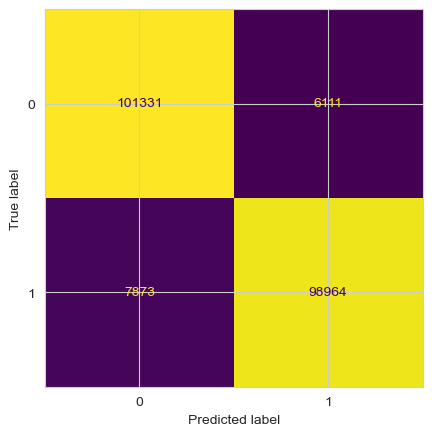

In [312]:
rt1=dt.datetime.now()

#Assign X and y to the object
My_Object=PL_Object(X,y)

#Build a simple pipeline

My_Pipeline=Pipeline([('X Prep',PreProcessor('X')),
                      ('X EnCat',EncodeCategorical('X')),
                      ('y EnCat',EncodeCategorical('y')),
                      ('DropCols',DropColumns()),
                      ('XGBoost',XGBoost())
                     ])

My_Object=My_Pipeline.transform(My_Object)

print()
print("The first result should be more or less equivalent to that of " + color.bold + \
      "Model 3 in Part 2." + color.end)
print()
print(color.bold + "Pipeline Process Completed." + color.end)

rt2=dt.datetime.now()
runtime(rt1,rt2)

<div class="alert alert-block alert-info" style="color:DarkSlateBlue">
    <b>Just for didactic reasons</b>, below shows how we can use data (dictionary) passed back by the pipeline to My_Object
    </div>      

In [313]:
My_Object.keys()

dict_keys(['xg_model', 'predictions', 'X_train', 'y_train', 'X_valid', 'y_valid', 'X_test', 'y_test'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999969 entries, 1021126 to 1225567
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Term               999969 non-null  int32  
 1   NoEmp              999969 non-null  int32  
 2   NewExist           999969 non-null  int32  
 3   CreateJob          999969 non-null  int32  
 4   RetainedJob        999969 non-null  int32  
 5   FranchiseCode      999969 non-null  int32  
 6   UrbanRural         999969 non-null  int32  
 7   LowDoc             999969 non-null  int32  
 8   DisbursementGross  999969 non-null  float64
 9   SBA_Appv           999969 non-null  float64
 10  Industry           999969 non-null  int32  
 11  Recession          999969 non-null  int32  
 12  RealEstate         999969 non-null  int32  
 13  SBA_Portion        999969 non-null  float64
 14  State_hash         999969 non-null  int64  
 15  CityState_hash     999969 non-null  int64  


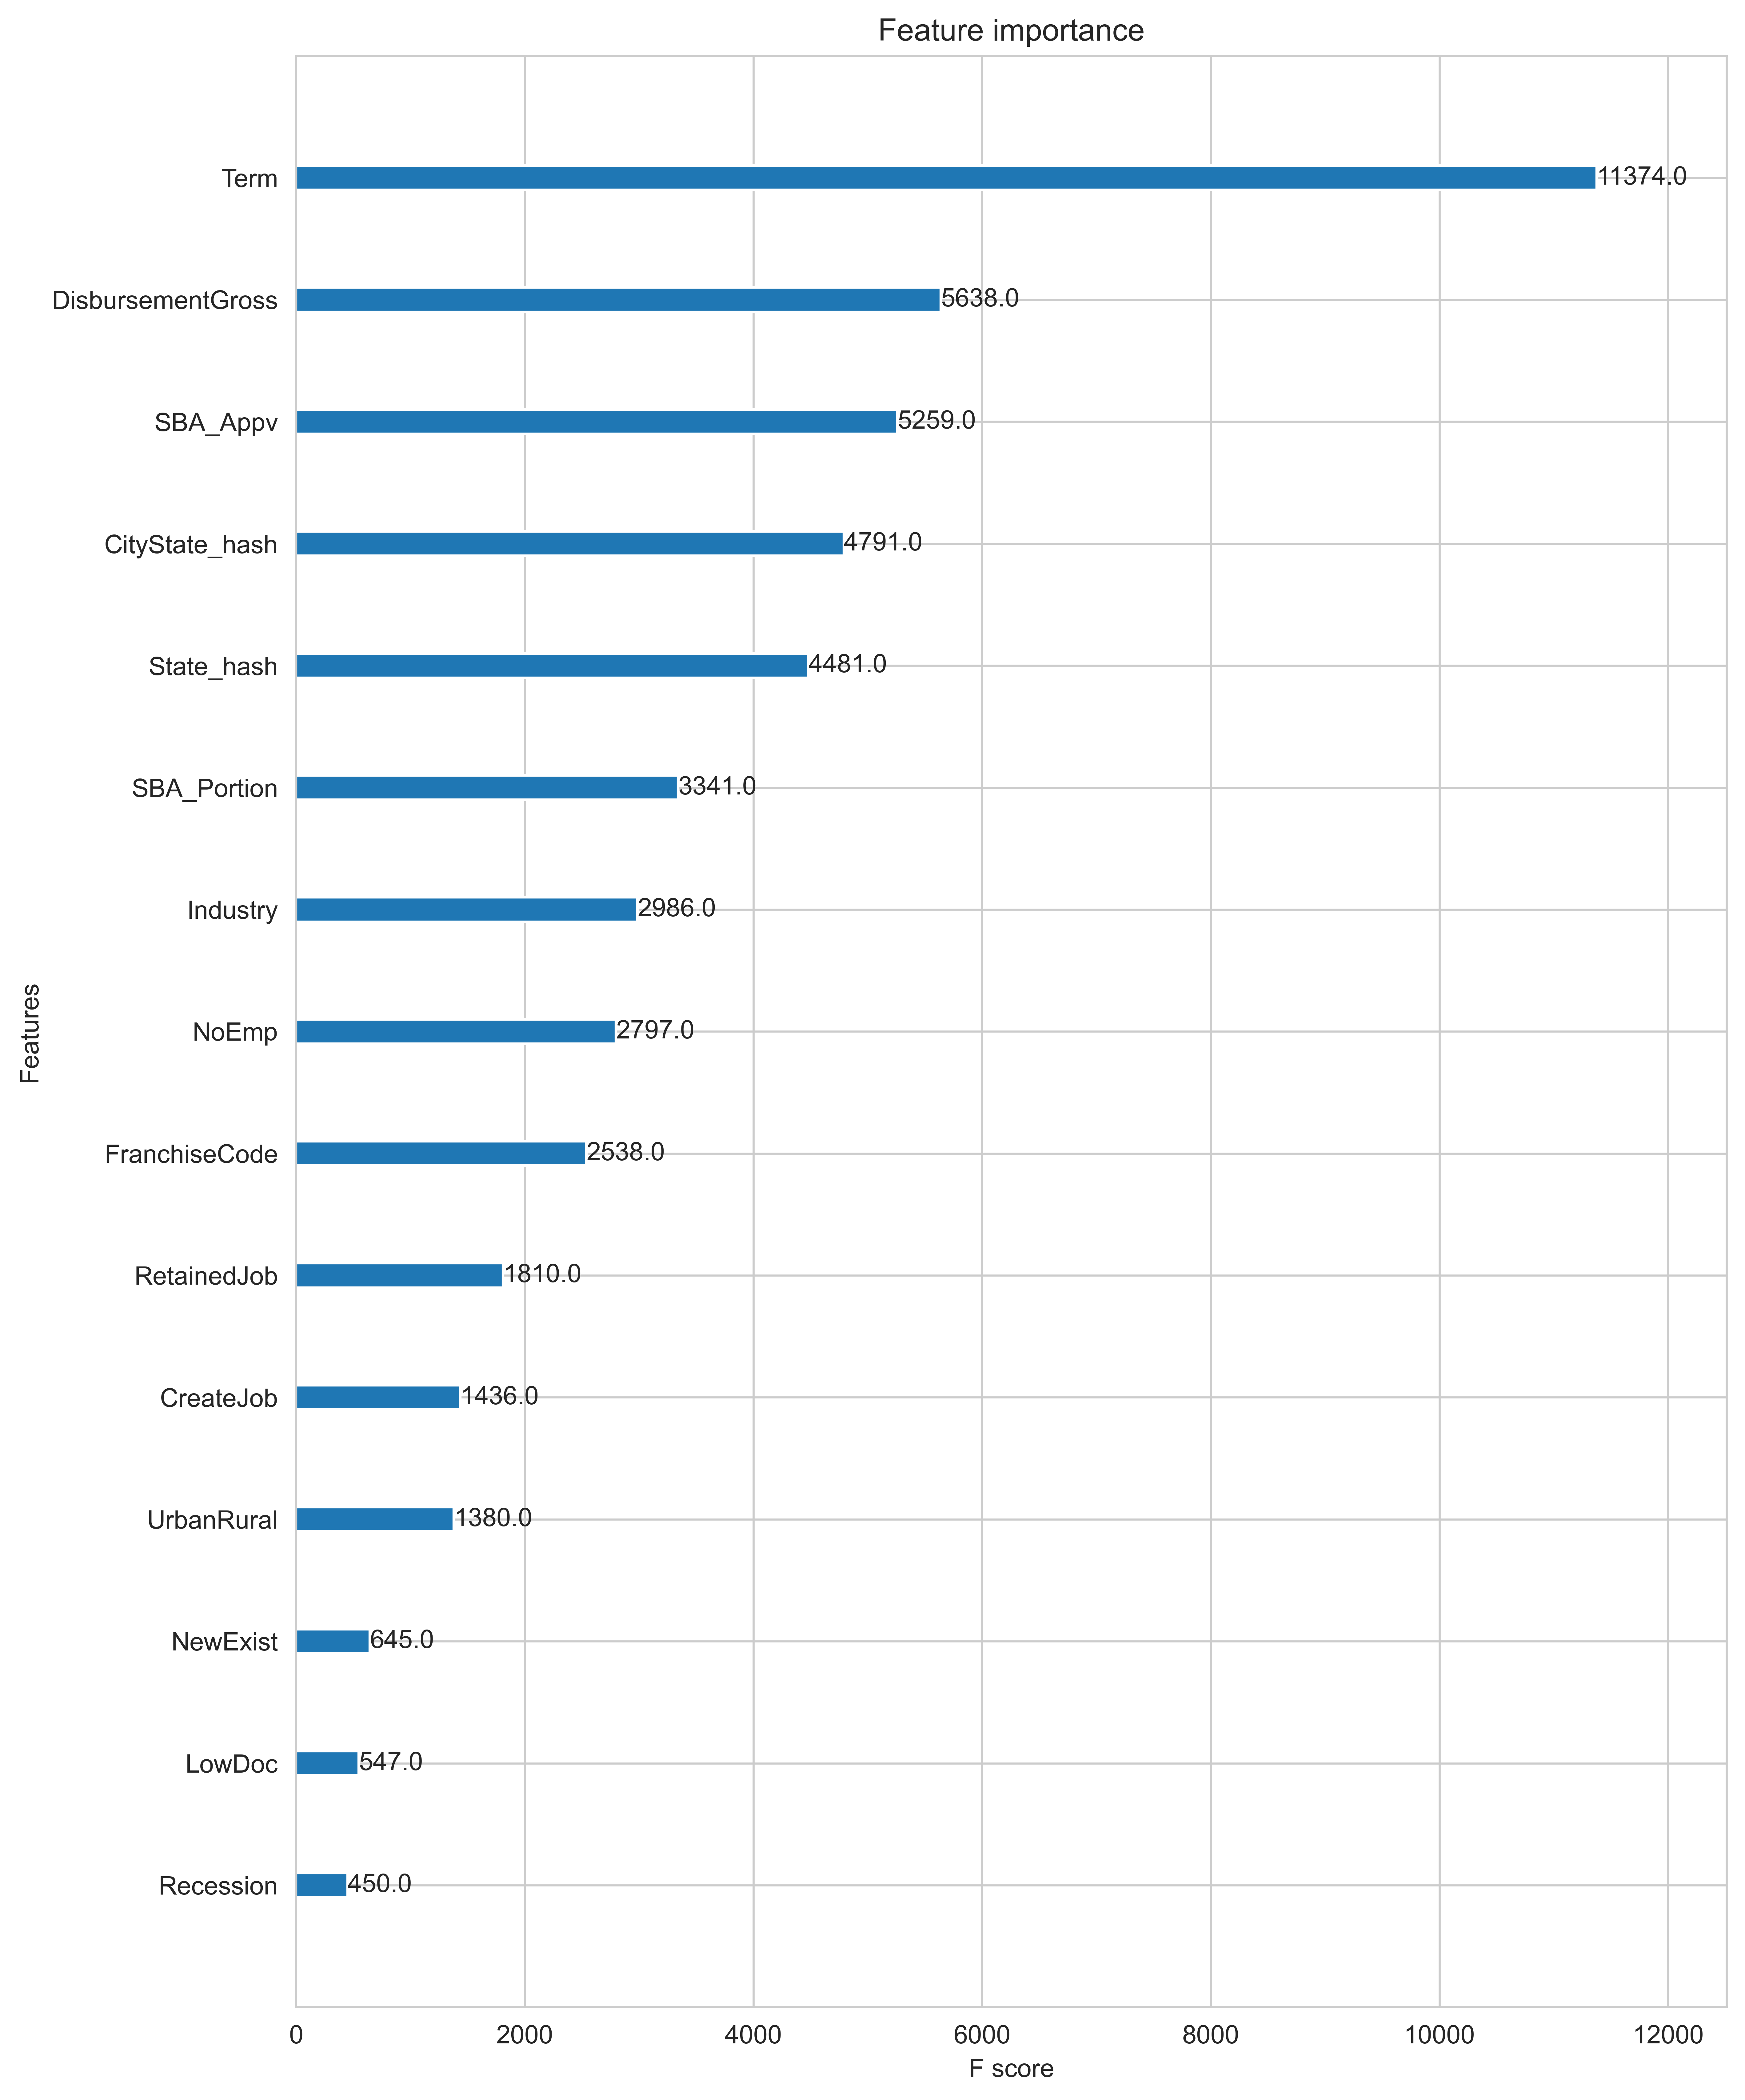

In [314]:
pl_model = My_Object['xg_model']
x=plot_features(pl_model, (10,14))
My_Object['X_train'].info()
print('x',x)

In [315]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("SBA Machine Learning PipeLine completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

<div style="font-family: Trebuchet MS;background-color:DarkRed;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3 style='color:GhostWhite;'>Part 2 : Data Exploration and Preparation, Modeling, Metrics</h3></div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3 style='color:GhostWhite;'>1. Load File</h3></div>

In [316]:
sba = pd.read_csv(filepath + 'SBAnational.csv',low_memory=False)
sba.head(2)

LoanNr_ChkDgt                         Name        City State    Zip  \
0     1000014003               ABC HOBBYCRAFT  EVANSVILLE    IN  47711   
1     1000024006  LANDMARK BAR & GRILLE (THE)   NEW PARIS    IN  46526   

               Bank BankState   NAICS ApprovalDate ApprovalFY  ...  RevLineCr  \
0  FIFTH THIRD BANK        OH  451120    28-Feb-97       1997  ...          N   
1   1ST SOURCE BANK        IN  722410    28-Feb-97       1997  ...          N   

   LowDoc  ChgOffDate  DisbursementDate  DisbursementGross  BalanceGross  \
0       Y         NaN         28-Feb-99        $60,000.00         $0.00    
1       Y         NaN         31-May-97        $40,000.00         $0.00    

   MIS_Status ChgOffPrinGr       GrAppv     SBA_Appv  
0       P I F       $0.00   $60,000.00   $48,000.00   
1       P I F       $0.00   $40,000.00   $32,000.00   

[2 rows x 27 columns]

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2. Data Exploration / Preparation</h2><br>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Prepare Pandas Profiler Report for a more detailed exploration</b><br>
    </div>

In [317]:
#profile = sba.profile_report(title='SBA Pandas Profiling Report')
# uncomment to save to an interactive html file
#profile.to_file(output_file="SBA_Profiling_Report.html")

print(color.bold + color.blue + "Please wait ... Profiling Report may take some time" + color.end)
sba.profile_report(title='SBA Pandas Profiling Report')

Please wait ... Profiling Report may take some time


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Reload dataset with some conversion</b><br>
    After review, decided to reload dataset with conversion of some features that may be needed for calculation
    </div>

In [428]:
sba = pd.read_csv(filepath + 'SBAnational.csv',\
                 converters = {'DisbursementGross':fixvals,'SBA_Appv':fixvals,\
                              'GrAppv':fixvals, 'ChgOffPrinGr':fixvals},\
                              parse_dates=['DisbursementDate'], \
                              low_memory=False)
print("Shape of SBA : ", sba.shape)
sba[['DisbursementGross','SBA_Appv','GrAppv','ChgOffPrinGr','DisbursementDate']].head(2)

Shape of SBA :  (899164, 27)


DisbursementGross   SBA_Appv     GrAppv ChgOffPrinGr DisbursementDate
0         60000.00   48000.00   60000.00         0.00        1999-02-28
1         40000.00   32000.00   40000.00         0.00        1997-05-31

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.1 Convert dtype</h2>
    </div>

In [429]:
# Convert dtype of some columns that will be used in calculation or string extraction
sba = sba.astype({'DisbursementGross':np.float64,'SBA_Appv':np.float64,\
                              'GrAppv':np.float64, 'ChgOffPrinGr':np.float64, 'NAICS':np.str_})

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.2 Drop rows or columns if needed</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns, as well as invalid categories</b></div>

In [ ]:
check_cols_with_nulls(sba)

['Name', 'City', 'State', 'Bank', 'BankState', 'NewExist', 'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate', 'MIS_Status']


In [ ]:
print(color.bold + color.underline + "Features with NA values" + color.end)
sba.isna().sum()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>DisbursementDate</b>
    </div>

In [ ]:
x = sba[sba['DisbursementDate'].isna()]
print(x.shape)

In [ ]:
# Not many nulls for DisbursementDate vis-a-vis to the dataset length, so drop rows with null
sba.dropna(subset=['DisbursementDate'], how='all', inplace=True)
x = sba[sba['DisbursementDate'].isna()]
print(x.shape)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RevLineCr</b></div>

In [ ]:
len(sba[(sba['RevLineCr'] != 'Y') & (sba['RevLineCr'] != 'N')])
# too many unknowns, we will drop 'RevlineCr' later

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b></div>

In [ ]:
sba['LowDoc'].isna().sum()

In [ ]:
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

In [ ]:
sns.countplot(x='LowDoc',data=sba)

* **LowDoc seems to have a bearing**

In [ ]:
# 5965 records that are not 'Y' or 'N', we can drop these rows
sba = sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')]
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

In [ ]:
len(sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NewExist</b>

In [ ]:
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

In [ ]:
sns.countplot(x='NewExist',data=sba)

In [ ]:
# 1154 records that are not 1 or 2, we can drop these rows as NewExist seems to have a bearing
sba = sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)]
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

In [ ]:
len(sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>CreateJob</b></div>

In [ ]:
len(sba[sba['CreateJob'].isna() == True])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RetainedJob</b></div>

In [ ]:
len(sba[sba['RetainedJob'].isna() == True])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>FranchiseCode</b></div>

In [ ]:
len(sba[sba['FranchiseCode'].isna()])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>UrbanRural</b></div>

In [ ]:
print(len(sba[sba['UrbanRural'].isna()]))
sba['UrbanRural'].unique()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NoEmp</b></div>

In [ ]:
len(sba[sba['NoEmp'].isna()])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Term</b></div>

In [ ]:
print(len(sba[sba['Term'].isna()]))
print(len(sba[sba['Term']==0]))
print(len(sba[sba['Term']<0]))

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>City</b></div>

In [ ]:
len(sba[sba['City'].isna()])

In [ ]:
# drop na in City column
sba = sba[sba['City'].notna()]
len(sba[sba['City'].isna()])

In [ ]:
sba.head(2)

In [ ]:
# Trim leading and trailing spaces
sba['City'] = sba['City'].str.strip()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>State</b></div>

In [ ]:
len(sba[sba['State'].isna()])

In [ ]:
# drop na in State column
sba = sba[sba['State'].notna()]
len(sba[sba['State'].isna()])

<div style="font-family: Trebuchet MS;background-color:Chocolate;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status<b> - this is the **target** variable</div>

In [ ]:
len(sba.loc[sba['MIS_Status'].isna()])

In [ ]:
# drop na in 'MIS_Status' column
sba = sba[sba['MIS_Status'].notna()]
len(sba[sba['MIS_Status'].isna()])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NAICS</b></div>

In [ ]:
len(sba[sba['NAICS'].isna()])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Name</b> - keeping this feature temporarily, in case it is needed
    </div>

In [ ]:
len(sba[sba['Name'].isna()])

In [ ]:
# drop rows with na in column 'Name'
sba.dropna(subset=['Name'], how='all', inplace=True)
len(sba[sba['Name'].isna()])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns</b></div>

In [ ]:
check_cols_with_nulls(sba)  # this function was defined earlier above

In [ ]:
# Save 2
sba.to_csv(savepath + "sba_save2.csv",index=False)
print('Saved to sba_save2.csv')
#FileLink(r'sba_save2.csv')  # Kaggle only

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.3 Create New Features</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Industry</b> - The industry sector is the 1st 2 digits of NAICS
    </div>

In [ ]:
sba['Industry'] = sba['NAICS'].str[0:2]
sba = sba.astype({'Industry':np.int32})

In [ ]:
sba['Industry'].head(2)

In [ ]:
sba['Industry'].unique()
# There is an invalid industry shown which is '0', caused by blank NAICS

In [ ]:
len(sba[sba['Industry'] == 0])
# This is a bummer, as industry sector has a big effect on a business, speaking as a business 
# domain expert.  Do we drop those with NAICS = 0 ?

In [ ]:
# At this stage, we leave it as is and treat it as unknown industry
sba.head(2)

In [ ]:
# Check if we can impute from the name.  For example, a bar (or similar) business
sba[(sba['Name'].str.contains('bar',case=False)) & (sba['Industry'] == 0)]\
    [['Name','Industry']].head(10)

**It's not feasible to impute missing Industry codes efficiently, so we abandon the idea.**

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Recession</b><br>
We want to account for variation due to the Great Recession (December 2007 to June 2009). Should we separate the datasets into different time periods ? Before, During, and After ?  Let's check how large the sets are later.  In the meantime, we create a new feature, Recession, with 1 for 'Y' and 0 for 'N' depending on the DisbursementDate. 
<br><br>
</div>

In [ ]:
# Convert "DisbursementDate" to datetime

# sba['DisbursementDate'] = pd.to_datetime(sba['DisbursementDate'], format='%d-%b-%y')

# sba.head(2)

In [ ]:
# Create new column based on condition
sba['Recession'] = np.where((sba['DisbursementDate'] >= '2007-09-01')\
                     & (sba['DisbursementDate'] <= '2009-06-30'), 1, 0)

In [ ]:
print(f'Total - {len(sba)}')
y = len(sba[sba['Recession'] == 1])
n = len(sba[sba['Recession'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Real Estate</b><br>
Loans backed by real estate will have terms 20 years or greater (≥240 months) and are the only loans granted for such a long term, whereas loans not backed by real estate will have terms less than 20 years ( < 240 months).<br><br>
1 - Backed By Real Estate<br>
0 - Not Backed By Real Estate<br><br>

In [ ]:
# Create new column based on condition
sba['RealEstate'] = np.where(sba['Term'] >= 240, 1, 0)

In [ ]:
print(f'Total - {len(sba)}')
y = len(sba[sba['RealEstate'] == 1])
n = len(sba[sba['RealEstate'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>SBA_Portion</b><br>
The portion which is the percentage of the loan that is guaranteed by SBA. This is derived by calculating the ratio of the amount of the loan SBA guarantees and the gross amount approved by the bank (SBA_Appv/GrAppv) * 100.<br><br></div>

In [ ]:
sba['SBA_Portion']=(sba['SBA_Appv']/sba['GrAppv']) * 100
sba.head(2)

**CityState**

In [ ]:
sba["CityState"] = sba["City"] + "_" + sba["State"]
sba[["CityState", "City", "State"]].head()

In [ ]:
sba.head(2)

In [ ]:
# Save 3
sba.to_csv(savepath + 'sba_save3.csv',index=False)
print('Saved to sba_save3.csv')
#FileLink(r'sba_save3.csv')  # Kaggle only

In [ ]:
#sba=pd.read_csv(savepath + 'sba_save3.csv', low_memory='False')

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>2.4 Encode Categorical Features</h2>
    </div>

In [ ]:
sba.select_dtypes(["object"]).nunique()

<div style="font-family: Trebuchet MS;background-color:Chocolate;color:AliceBlue;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status</b><br>
    This will be the <b>target</b> variable</div>

In [ ]:
sns.set_style('whitegrid')
# Target variable is MIS Status, a categorical variable

print(sba['MIS_Status'].value_counts())
sns.countplot(x='MIS_Status',data=sba)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    This shows a skewed distribution, where this bias in the target can influence many machine learning algorithms, leading some to ignore the minority class entirely, in this case, CHGOFF.  Before oversampling the data, will try as is.<br><br></div>

In [ ]:
# Update column based on condition
sba['MIS_Status'] = np.where((sba['MIS_Status'] == 'P I F'), 1, 0)

In [ ]:
print(sba['MIS_Status'].dtype)
sba.head(2)[['City','MIS_Status']]

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b><br>
'Y' = 1<br>
'N' = 0

In [ ]:
# Update column based on condition
sba['LowDoc'] = np.where((sba['LowDoc'] == 'Y'), 1, 0)

sba.head(2)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Others</b></div>

In [ ]:
# will not hash 'City' as it is already covered by 'CityState'

cols_to_drop = []
hash_constant = 900000   # fixed value so we can programmatically reproduce the hash when needed
len_data=len(sba)
for col in sba[['State','CityState']]:
  if sba[col].dtype == 'object':
    print(f'Column {col} has {sba[col].nunique()} values among {len_data}')

    if sba[col].nunique() < 25:
      print(f'One-hot encoding of {col}')
      one_hot_cols = pd.get_dummies(sba[col])
      for ohc in one_hot_cols.columns:
        sba[col + '_' + ohc] = one_hot_cols[ohc]
    else:
      print(f'Hashing of {col}')
      sba[col + '_hash'] = sba[col].apply(lambda row: int(hashlib.sha1((col + "_" + \
                                    str(row)).encode('utf-8')).hexdigest(), 16) % hash_constant)

    cols_to_drop.append(col)
print(cols_to_drop)

In [ ]:
sba.head(2)[['State','CityState','State_hash','CityState_hash']]

In [ ]:
sba.info()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Convert small fields to dtype int32<b></div>

In [ ]:
sba = sba.astype({'Term':np.int32, 'NoEmp':np.int32, 'NewExist':np.int32, \
                    'CreateJob':np.int32, 'RetainedJob':np.int32,\
                    'FranchiseCode':np.int32, 'UrbanRural':np.int32,\
                    'Industry':np.int32}) 

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>TimeFrame</b><br>
Save a dataset for later use where we restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.
    <br><br>

In [ ]:
sba_bef_2011 = sba[sba['DisbursementDate'] <= '2010-12-31'].copy()
len(sba_bef_2011[sba_bef_2011['DisbursementDate'] > '2010-12-31'])

In [ ]:
len(sba[sba['DisbursementDate'] > '2010-12-31'])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Drop columns that are no longer needed<b></div>

In [ ]:
# Save 4
sba.to_csv(savepath + 'sba_save4.csv',index=False)
print('sba_save4.csv saved')
#FileLink(r'sba_save4.csv')         # Kaggle only

In [ ]:
cols_to_drop = ['LoanNr_ChkDgt', 'Bank', 'BankState', 'ApprovalDate', \
                        'ApprovalFY', 'ChgOffDate', 'BalanceGross', 'NAICS', 'ChgOffPrinGr', \
                        'Name', 'RevLineCr', 'DisbursementDate', 'City', 'State', 'CityState',\
                         'GrAppv','Zip']

sba_bef_2011.drop(columns=cols_to_drop, inplace=True)

sba.drop(columns=cols_to_drop, inplace=True)

print('Unneeded Columns Dropped')
print(sba.info())

In [ ]:
# Save sba_bef_2011
## save this dataset to working dir
sba_bef_2011.to_csv(savepath + "sba_bef_2011.csv",index=False)
print("sba_bef_2011.csv saved")
#FileLink(r'sba_bef_2011.csv')  # Kaggle only

In [ ]:
# Save 5
sba.to_csv(savepath + 'sba_save5.csv',index=False)
print('sba_save5.csv saved')
#FileLink(r'sba_save5.csv')         # Kaggle only

In [ ]:
print(len(sba))
print(len(sba_bef_2011))

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for Infinite Values<b></div>

In [ ]:
check_infinity_nan(sba,'sba')

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check Correlations</b></div>

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

g = sns.heatmap(
    sba.corr(),
    annot=True,
    ax=ax,
    cmap='OrRd',
    cbar=False,
    linewidth=1
)

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>3. Build Model Using XGBoost</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>3.1 Prepare Data</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>3.1 Model 1</h2>
    </div>

In [ ]:
# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

In [ ]:
rt1=dt.datetime.now()

model1 = process_model(X, y)
model1_results = model1.prep_run_model(0.7, "Metrics : Full SBA Not Oversampled")

rt2=dt.datetime.now()
runtime(rt1,rt2)

<div class="alert alert-block alert-info">
    <b>Accuracy for model is good; but ...</b> Precision, Recall, and f1-score of minority class 0 (CHGOFF) is <b>much lower</b> than that of 1 (P I F). This is because MIS_Status is heavily skewed towards 1 (P I F).<br><br>
In such a scenario, <b>Accuracy is not a good metric</b>, as it favors the majority.  <b>The f1-score is the more ideal metric</b>, which correctly shows a poorer score by the minority class.<br><br>
    To solve this, we try <b>Oversampling the data</b>, in the next section.</div>

In [ ]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("SBA Machine Learning Model 1 completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;"><h2 style='color:GhostWhite;'>3.2 OverSample</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;"><h2 style='color:GhostWhite;'>3.2.1 Model 2</h2>
    </div>

In [ ]:
# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

In [ ]:
rt1=dt.datetime.now()

model2 = process_model(X, y)
model2.osample()
model2_results = model2.prep_run_model(0.7, "Metrics : Full SBA Oversampled")

rt2=dt.datetime.now()
runtime(rt1,rt2)

<div class="alert alert-block alert-info">
    After oversampling of the minority class, class 0 (CHGOFF) <b>now has a similar </b> precision, recall, and f1-score as class 1 (P I F).
<br><br>     
    The <b>accuracy score</b> is slightly lower than when not oversampled, but this should be a good metric now as the target classification is no longer imbalanced, and <b>the model is now more accurate in predicting the target.</b></div>

In [ ]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("SBA Machine Learning Model 2 completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

In [ ]:
# Plot feature importance

plot_features(model2_results['xg_model'], (10,12))

<div class="alert alert-block alert-info">
    <b>Observation</b><br>
    I was hoping to see <b>Industry</b> at a much higher position here, but apparently the incomplete data on industry had an effect.<br><br>
Furthermore, <b>Recession</b> has to be at a very high position, but is at the bottom instead.  This could be due to <b>Recession</b> data being highly skewed towards 1 (Not Recession).<br><br>
<b>Real Estate</b> should have good importance too, but it may be highly skewed as well.

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>3.2.2 Model 3</h2>
    <b>Build a Model Dataset Excluding Year 2011 and Above</b>

We restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.
       </div>

In [ ]:
sba_df = pd.read_csv(savepath + "sba_bef_2011.csv")

print(sba_df.columns)

# Select subset of predictors
X = sba_df.copy()

# Select target
y = X.pop('MIS_Status')

In [ ]:
rt1=dt.datetime.now()

model3 = process_model(X, y)
model3.osample()
model3_results = model3.prep_run_model(0.7, "Metrics : SBA Before 2011 Oversampled")

rt2=dt.datetime.now()
runtime(rt1,rt2)

<div class="alert alert-block alert-info">
    <b>We get a slightly better score.</b>  Will use this dataset as the last dataset, for now.</div>

In [ ]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("SBA Machine Learning Model 3 completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

In [ ]:
# Plot feature importance
my_model3 = model3_results['xg_model']
plot_features(my_model3, (10,14))

In [ ]:
# Save 6
sba_df.to_csv(savepath + 'sba_save6.csv',index=False)
print('sba_save6.csv saved')
#FileLink(r'sba_save6.csv')  # Kaggle only

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>4. Test Model</h2>
    </div>
    

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>4.1 Test Model with Test Dataset</h2>
    Test Dataset was previously unseen by the model.
    </div>

In [ ]:
X_test = model3_results['X_test']
y_test = model3_results['y_test']

In [ ]:
# Get predictions
predictions6 = my_model3.predict(X_test)
model_eval(y_test, predictions6)
print() # to suppress printing return value of model_eval()

In [ ]:
X_test.info()

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>4.2 Test Model with User Input</h2>
    </div>

<div class="alert alert-block alert-info">So let's assume the following are <b>the entries of a user</b>, through a user interface, looking for a prediction from our model.</div>

In [ ]:
sba.loc[sba['MIS_Status']=='CHGOFF'].iloc[0]

In [ ]:
# User Input test 1

# 16 entries
user_input =   {'Term':50, 
                'NoEmp':0,
                'NewExist':1,
                'CreateJob':0 ,          
                'RetainedJob':0,         
                'FranchiseCode':1,       
                'UrbanRural':0,           
                'LowDoc':0,               
                'DisbursementGross':50000,                 
                'SBA_Appv':25000,          
                'Industry':71, 
                'Recession':0,
                'RealEstate':0,           
                'SBA_Portion':50,
                'City':'EVANSVILLE',
                'State':'IN'
               }

#user_input_list = [50,0,1,0,0,1,0,0,50000,25000,71,0,0,50,'EVANSVILLE','IN']

city = user_input['City']
state = user_input['State']
city_state = city + "_" + state

state_hash = int(hashlib.sha1(('State' + "_" + \
                              str(state)).encode('utf-8')).hexdigest(), 16) % 900000
city_state_hash = int(hashlib.sha1(('CityState' + "_" + \
                              str(city_state)).encode('utf-8')).hexdigest(), 16) % 900000

print(f'State_hash = {state_hash}')
print(f'CityState_hash = {city_state_hash}')

user_input.pop('City')
user_input.pop('State')
user_input['State_hash'] = state_hash
user_input['CityState_hash'] = city_state_hash

user_input_list = list(user_input.values())

print()
print(color.bold + "User Entry:" + color.end)
user_input

In [ ]:
features = np.array([user_input_list])   

# using inputs to predict the output
pred = my_model3.predict(features)
if pred[0] == 1:
    print(color.bold + color.blue + "Prediction: Approve The Loan" + color.end)
else:
    print(color.bold + color.red + "Prediction: Do Not Approve The Loan" + color.end)

In [ ]:
# User Input test 2

'''
# if one wants to edit the list from the previous cell
user_input2_list = user_input_list[:]   # make a copy
user_input2_list[0] = 500          # change term 
'''

user_input2 = copy.deepcopy(user_input)
user_input2['Term'] = 500     # change term
user_input2_list = list(user_input2.values())

features = np.array([user_input2_list]) 

# using inputs to predict the output
pred = my_model3.predict(features)
if pred[0] == 1:
    print(color.bold + color.blue + "Prediction: Approve The Loan" + color.end)
else:
    print(color.bold + color.red + "Prediction: Do Not Approve The Loan" + color.end)

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 15px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;border: 5px solid CadetBlue;"><b>Predictions:</b><br>
    
- 1 -> can approve<br>
- 0 -> do not approve<br>

Of course, in real life, will need to check further using other data (e.g. financial statements, kind of real estate, etc.) or other data's models if available.

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>5. Mutual Information Scores</h2>
 "A general-purpose metric, normally used before selecting and building a model, but used here in the end, for comparison.  Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships."
    </div>

In [ ]:
sba_df = pd.read_csv(savepath + "sba_save6.csv")
print(sba_df.columns)

# Select subset of predictors
X = sba_df.copy()

# Select target
y = X.pop('MIS_Status')

In [ ]:
rt1=dt.datetime.now()

# a long time to run
model_mi = process_model(X, y)
osample_xy = model_mi.osample()
mi_scores = make_mi_scores(osample_xy['X_over'], osample_xy['y_over'])

rt2=dt.datetime.now()
runtime(rt1,rt2)

In [ ]:
mi_scores

In [ ]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("SBA Mutual Information completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

In [ ]:
plt.figure(dpi=1200, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [ ]:
# Plot feature importance
plot_features(my_model3, (10,14))

<div class="alert alert-block alert-info">
The importance ranked by <b>Mutual Information</b> and <b>XGBoost Feature Importance</b> metrics are different.  Which ranking do you think is more reasonable ?</div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>6. Trim Dataset</h2><br>
After the preprocessing and encoding steps, not all of the features may be useful in forecasting the loan default. Alternatively we can select the <b>top 5 or top 8 features</b>, based on the feature importance plot above, which had a major contribution in forecasting loan defaults.<br><br>

If the model performance is similar in both the cases, that is – by using all the features and by using 5-8 features, then we should use only the top 8 features, in order to keep the model simpler and more efficient.

The idea is to have a less complex model without compromising on the overall model performance.
</div>

In [ ]:
sba = pd.read_csv(savepath + "sba_save6.csv")
print(sba.shape)

# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

#Let's retain the top 8 from Mutual Information metric 
mi_features = ['Term', 'DisbursementGross', 'SBA_Appv', 'SBA_Portion', 'CityState_hash', \
         'FranchiseCode', 'RealEstate','UrbanRural']

Xmi = X[mi_features]

#Let's retain the top 8 from Feature Importance metric 
fi_features = ['Term', 'DisbursementGross', 'SBA_Appv', 'CityState_hash','State_hash', \
                 'SBA_Portion', 'NoEmp', 'Industry']

Xfi = X[fi_features] 

In [ ]:
rt1=dt.datetime.now()

model_mi = process_model(Xmi, y)
model_mi.osample()
model_mi_results = model_mi.prep_run_model(0.7, "Mutual Information Metrics")

rt2=dt.datetime.now()
runtime(rt1,rt2)

In [ ]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("Trimmed Dataset by Mutual Information completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

In [ ]:
# Plot mutual information
my_model_mi = model_mi_results['xg_model']
plot_features(my_model_mi, (10,5))

In [ ]:
# Test with Unseen test data

X_test = model_mi_results['X_test']
X_test_mi = X_test[mi_features]

y_test = model_mi_results['y_test']

predictions_mi = my_model_mi.predict(X_test_mi)
model_eval(y_test, predictions_mi)

In [ ]:
rt1=dt.datetime.now()

model_fi = process_model(Xfi, y)
model_fi.osample()
model_fi_results = model_fi.prep_run_model(0.7, "Feature Importance Metrics")

rt2=dt.datetime.now()
runtime(rt1,rt2)

In [ ]:
if alert_flag == 1:
    if kaggle_flag == 0:   # not Kaggle
        engine.say("Trimmed Dataset by Feature Importance completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))

In [ ]:
# Plot feature importance
my_model_fi = model_fi_results['xg_model']
plot_features(my_model_fi, (10,5))

In [ ]:
# Test with Unseen test data

X_test = model_fi_results['X_test']
X_test_fi = X_test[fi_features]

y_test = model_fi_results['y_test']

predictions_fi = my_model_fi.predict(X_test_fi)
model_eval(y_test, predictions_fi)

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 20px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2 style='color:GhostWhite;'>7. Results</h2>
</div>

<div class="alert alert-block alert-info">
    <b>Do we select the full dataset, or the trimmed dataset ?</b><br><br>
    <b>Observation:</b><br>
    <ul>
        <li><b>Accuracy</b> - Approx 1 point more or less accuracy difference between trimmed and full features dataset.<br><br>
        <li><b>f1-score</b> - Same f1-score between full features dataset and Manual Information trimmed dataset.  0.01 difference between full features dataset and Feature Importance trimmed dataset.<br><br>
    </ul>
    We can <b>stick with the full features</b> for now; but the trimmed features are also good, with the <b>Manual Information trimmed dataset</b> very slightly favored.

In [ ]:
if alert_flag == 1:
    if kaggle_flag == 0:
        engine.say("SBA Machine Learning completed.")
        engine.runAndWait()
    else:
        display(Audio(url=audio_path, autoplay=True))